In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation
import random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open, mid_cum_Z4_sec
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
EXP2_


# Download data

In [4]:
#cleaned mvt data
df_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df_init.shape)
df_init.head(3)

(2099229, 23)


,Unnamed: 0,Timestamp,HenID,Zone,PenID,ts_order,TagID,signalstrength,system,time,...,zone3,zone4,next_record_date,duration,next_zone,previous_zone,is_dur_smaller_60sec,correction_is_consecutive_equal_initial_zone,is_WG_open,is_day
0,132,2021-10-08 00:24:41,hen_1,3_Zone,pen10,348506,tag_5,14,10 - 12,00:24:41,...,6,0,2021-10-08 10:59:30,38089.0,2_Zone,NaN,False,False,False,False
1,1274,2021-10-08 10:59:30,hen_1,2_Zone,pen10,348747,tag_5,5,10 - 12,10:59:30,...,0,0,2021-10-09 10:33:27,84837.0,2_Zone,3_Zone,False,False,False,True
2,6916,2021-10-09 10:33:27,hen_1,3_Zone,pen10,350158,tag_5,15,10 - 12,10:33:27,...,4,6,2021-10-09 10:59:56,1589.0,3_Zone,2_Zone,False,False,False,True


In [5]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_added.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

(7597, 68)


,HenID,level,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,dur_values_normalized,...,day_lighth,mid_durationafterlightturnedon_Z4_h_Morning,mid_cum_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h,Period_type,HenID_Period,HenID_date,system,CorrectPenID
0,hen_1,2021-10-09,28415.0,3985.0,0.0,0.0,32400.0,9.0,"[28415.0, 3985.0, 0.0, 0.0]","[0.8770061728395062, 0.12299382716049383, 0.0,...",...,8,NaN,NaN,NaN,NaN,early,hen_1_early,hen_1-2021-10-09,10-12,pen10
1,hen_1,2021-10-10,21881.0,9182.0,1337.0,0.0,32400.0,9.0,"[21881.0, 9182.0, 1337.0, 0.0]","[0.6753395061728396, 0.28339506172839507, 0.04...",...,8,NaN,NaN,NaN,NaN,early,hen_1_early,hen_1-2021-10-10,10-12,pen10
2,hen_1,2021-10-16,27548.0,4852.0,0.0,0.0,32400.0,9.0,"[27548.0, 4852.0, 0.0, 0.0]","[0.850246913580247, 0.14975308641975307, 0.0, ...",...,8,NaN,NaN,NaN,NaN,early,hen_1_early,hen_1-2021-10-16,10-12,pen10


In [6]:
print(list(df_daily.columns))

['HenID', 'level', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_2_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'Total_number_zone', 'list_of_durations', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_distance', 'nestboxes_related_behavior', 'nbr_stays_total', 'nbr_stays_3_Zone', 'nbr_stays_2_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'TagID', 'night_level', 'night_Max_duration_zones', 'night_duration_Z5', 'night_Total_number_transition', 'is_mvt_night', 'nbr_h_per_day', 'correct_amount_of_hour', 'DOA', 'WOA', 'duration_1_Zone', 'perc_duration_1_Zone', 'perc_1_Zone_while_WG_open

In [7]:
df_daily['Period_type'].value_counts()

R3       2452
R2       1923
R1       1314
late     1101
early     807
Name: Period_type, dtype: int64

# Daily Variables

In [8]:
li_var = list(df_daily.columns)
li_general = ['HenID', 'level','CorrectPenID']
li_var_TODO = li_var #keep track of the columns that still needs to be verified
len(li_var_TODO)
#display(list(li_var))

68

In [9]:
df_daily[df_daily['vertical_travel_distance_perinsideh'].isnull()][['vertical_travel_distance_perinsideh','duration_1_Zone','level']]

,vertical_travel_distance_perinsideh,duration_1_Zone,level


In [10]:
#print all column # nan
df_daily.isna().sum(axis=0).sort_values().tail(20)
#note there is 807 obs in the "early" period, when the WG is close
#noet also that the "early" period hav ethe artificiel light turned on at 8h so no mid-time nestbox usage variables are computed
#note: the mid-time nestbox zone usgae are nan when the bird did not visited that zone in the ornin, whic happened 930-807 time 
#which sounds reasonable

perc_duration_5_Zone                              0
duration_sincedaystarted_beforeWGopened_sec       0
FirstTimestamp_3_Zone                           158
FirstTimestamp_2_Zone                           208
FirstTimestamp_5_Zone                           421
mid_cum_Z4_sec                                  480
FirstTimestamp_4_Zone                           480
latency_1_Zone_h                                807
perc_1_Zone_while_WG_open                       807
perc_duration_1_Zone                            807
duration_1_Zone                                 807
nbr_stays_1_Zone                                807
nbr_h_WGopen                                    807
mid_durationafterlightturnedon_Z4_h_Morning     930
mid_cum_Z4_h_Morning                            930
previous_mid_cum_Z4_h_Morning                  2068
Intervaltime_midcumZ4hmorning_h                2122
FirstTimestamp_1_Zone_sec                      3068
FirstTimestamp_1_Zone                          3068
nestboxes_re

# food related behavior

#will be better checked visually in 4.b. notebook (more easy)
display(df_daily[df_daily['food_related_behavior_final']>0.5].tail(3))
h = 'hen_29'
d = dt.datetime(2020,10,19)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|\
                                         (df_daily['level']==(d+dt.timedelta(days=1))))][li_general+['food_related_behavior_final']].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))

## Night

In [11]:
df_daily['night_duration_Z5'].value_counts(normalize=True).head(10)

36000    0.472555
0        0.335264
54000    0.038699
37800    0.023825
25200    0.010267
35943    0.000527
35799    0.000527
35956    0.000527
35701    0.000395
35961    0.000395
Name: night_duration_Z5, dtype: float64

In [12]:
li_night = [i for i in li_var_TODO if ('night' in i)]+[i for i in li_var_TODO if ('sleeping' in i.lower())]
li_night

['night_level',
 'night_Max_duration_zones',
 'night_duration_Z5',
 'night_Total_number_transition',
 'is_mvt_night',
 'SleepingHeight',
 'Sleeping_NotUppest',
 'Sleeping_Uppest']

In [13]:
df_daily['SleepingHeight'].unique()

array([0, 1, 3, 2], dtype=int64)

In [14]:
#NOTE: for completness we kept the night after the RFID was turned back on as it shouldnt be inlfencing the night time, but ¨
#just the transitions to the litter
df_daily[df_daily['Period_type']=='R1'][li_night+li_general]

,night_level,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,SleepingHeight,Sleeping_NotUppest,Sleeping_Uppest,HenID,level,CorrectPenID
807,2021-11-23_24,3_Zone,0,0,0,1,1,0.0,hen_1,2021-11-23,pen10
808,2021-11-24_25,3_Zone,0,0,0,1,1,0.0,hen_1,2021-11-24,pen10
809,2021-11-25_26,3_Zone,0,0,0,1,1,0.0,hen_1,2021-11-25,pen10
810,2021-11-26_27,3_Zone,0,0,0,1,1,0.0,hen_1,2021-11-26,pen10
811,2021-11-27_28,3_Zone,0,0,0,1,1,0.0,hen_1,2021-11-27,pen10
...,...,...,...,...,...,...,...,...,...,...,...
2116,2021-11-26_27,5_Zone,35645,1,1,3,0,1.0,hen_99,2021-11-26,pen4
2117,2021-11-27_28,5_Zone,36000,0,0,3,0,1.0,hen_99,2021-11-27,pen4
2118,2021-11-28_29,5_Zone,35605,1,1,3,0,1.0,hen_99,2021-11-28,pen4
2119,2021-11-29_30,3_Zone,0,1,1,1,1,0.0,hen_99,2021-11-29,pen4


In [15]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_night]
print(len(li_var_TODO))

60


# first timestamp in each zones & WG latency

In [16]:
li_latency = [i for i in li_var if 'latency_' in i]
li_first_timestamp = [i for i in li_var if 'FirstTimestamp' in i]+['Total_number_zone']

In [17]:
#random bird
h = 'hen_89'
d = dt.datetime(2021,11,24) #until 3h30-17h00 day time and wg opened at 10h
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp+li_latency])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,CorrectPenID,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone,latency_1_Zone_h
2026,hen_89,2021-11-24,pen4,2021-11-24 06:58:41,2021-11-24 03:34:54,2021-11-24 03:40:41,2021-11-24 03:30:00,2021-11-24 11:55:25,42925.0,5.0,1.923611


((Timestamp('2021-11-24 03:34:54'), '3_Zone'),
 (Timestamp('2021-11-24 03:40:41'), '4_Zone'),
 (Timestamp('2021-11-24 03:44:37'), '5_Zone'),
 (Timestamp('2021-11-24 03:45:48'), '4_Zone'),
 (Timestamp('2021-11-24 03:54:28'), '3_Zone'),
 (Timestamp('2021-11-24 03:56:08'), '4_Zone'),
 (Timestamp('2021-11-24 04:09:43'), '5_Zone'),
 (Timestamp('2021-11-24 04:10:59'), '4_Zone'),
 (Timestamp('2021-11-24 04:47:50'), '3_Zone'),
 (Timestamp('2021-11-24 04:57:31'), '5_Zone'),
 (Timestamp('2021-11-24 06:53:43'), '4_Zone'),
 (Timestamp('2021-11-24 06:58:41'), '2_Zone'),
 (Timestamp('2021-11-24 07:27:36'), '3_Zone'),
 (Timestamp('2021-11-24 07:36:21'), '4_Zone'),
 (Timestamp('2021-11-24 07:43:40'), '5_Zone'),
 (Timestamp('2021-11-24 08:44:57'), '4_Zone'),
 (Timestamp('2021-11-24 08:52:08'), '5_Zone'),
 (Timestamp('2021-11-24 08:59:04'), '4_Zone'),
 (Timestamp('2021-11-24 09:34:37'), '3_Zone'),
 (Timestamp('2021-11-24 09:38:23'), '2_Zone'),
 (Timestamp('2021-11-24 09:44:22'), '4_Zone'),
 (Timestamp('

In [18]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_first_timestamp]
li_var_TODO = [i for i in li_var_TODO if i not in li_latency]
len(li_var_TODO)

52

# Transitions & vertical distance

In [19]:
li_transition = [i for i in li_var_TODO if ('vertical_travel' in i) | ('transition' in i)| ('stay' in i)]+['Total_number_zone']
li_transition

['Total_number_transition',
 'nbr_stays',
 'vertical_travel_distance',
 'nbr_stays_total',
 'nbr_stays_3_Zone',
 'nbr_stays_2_Zone',
 'nbr_stays_4_Zone',
 'nbr_stays_5_Zone',
 'nbr_stays_1_Zone',
 'vertical_travel_distance_perinsideh',
 'Total_number_zone']

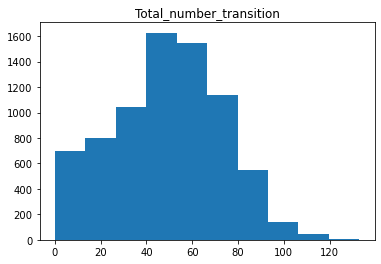

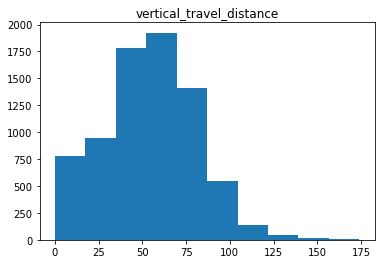

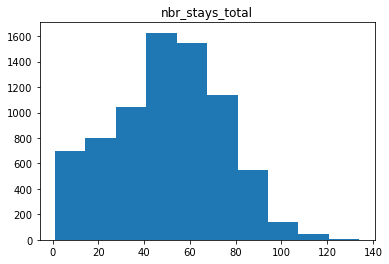

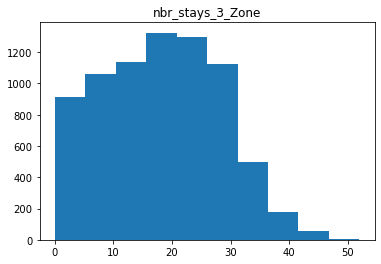

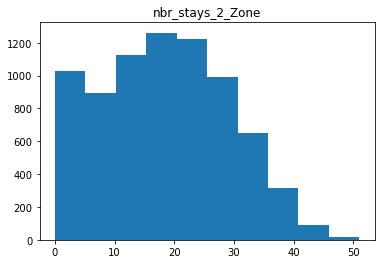

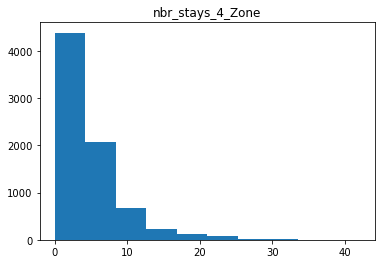

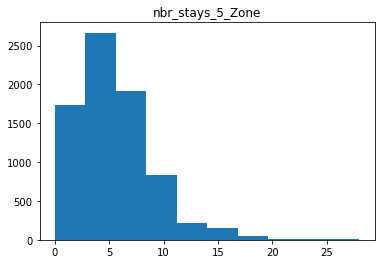

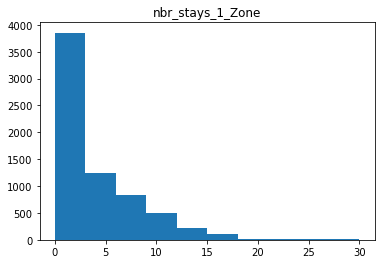

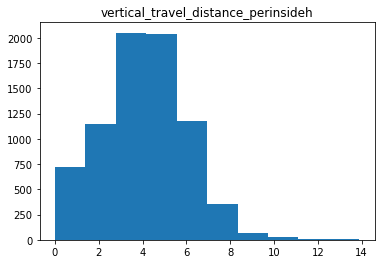

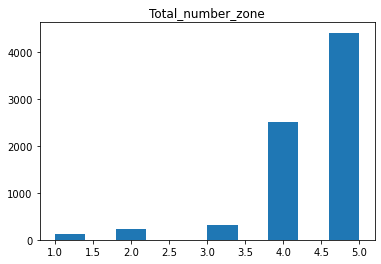

In [20]:
for x in li_transition:
    #remove the dico
    if x!='nbr_stays':
        plt.hist(df_daily[x])
        plt.title(x)
        plt.show()

In [21]:
df_daily[df_daily['vertical_travel_distance']>0][li_general+li_transition].head(3)

,HenID,level,CorrectPenID,Total_number_transition,nbr_stays,vertical_travel_distance,nbr_stays_total,nbr_stays_3_Zone,nbr_stays_2_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone,nbr_stays_1_Zone,vertical_travel_distance_perinsideh,Total_number_zone
0,hen_1,2021-10-09,pen10,6.0,"{'2_Zone': 4, '3_Zone': 3}",6.0,7.0,3.0,4.0,0.0,0.0,NaN,0.666667,2.0
1,hen_1,2021-10-10,pen10,14.0,"{'2_Zone': 6, '3_Zone': 7, '4_Zone': 2}",14.0,15.0,7.0,6.0,2.0,0.0,NaN,1.555556,3.0
2,hen_1,2021-10-16,pen10,6.0,"{'2_Zone': 4, '3_Zone': 3}",6.0,7.0,3.0,4.0,0.0,0.0,NaN,0.666667,2.0


In [22]:
#random bird
h = 'hen_8'
d = dt.datetime(2022,2,2) #until 3h00-17h00 day time and wg opened at 10h-16h20
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==d-dt.timedelta(days=1)))]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_transition])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,CorrectPenID,Total_number_transition,nbr_stays,vertical_travel_distance,nbr_stays_total,nbr_stays_3_Zone,nbr_stays_2_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone,nbr_stays_1_Zone,vertical_travel_distance_perinsideh,Total_number_zone
3836,hen_8,2022-02-02,pen10,19.0,"{'5_Zone': 8, '2_Zone': 7, '4_Zone': 2, '3_Zon...",42.0,20.0,3.0,7.0,2.0,8.0,0.0,3.0,4.0


((Timestamp('2022-02-01 04:04:38'), '2_Zone'),
 (Timestamp('2022-02-01 04:12:12'), '4_Zone'),
 (Timestamp('2022-02-01 04:49:23'), '5_Zone'),
 (Timestamp('2022-02-01 05:37:11'), '2_Zone'),
 (Timestamp('2022-02-01 06:07:17'), '3_Zone'),
 (Timestamp('2022-02-01 06:14:10'), '2_Zone'),
 (Timestamp('2022-02-01 06:47:17'), '3_Zone'),
 (Timestamp('2022-02-01 06:53:04'), '2_Zone'),
 (Timestamp('2022-02-01 07:01:41'), '5_Zone'),
 (Timestamp('2022-02-01 08:01:22'), '2_Zone'),
 (Timestamp('2022-02-01 09:59:14'), '3_Zone'),
 (Timestamp('2022-02-01 10:00:53'), '5_Zone'),
 (Timestamp('2022-02-01 10:08:58'), '2_Zone'),
 (Timestamp('2022-02-01 11:40:13'), '5_Zone'),
 (Timestamp('2022-02-01 12:06:38'), '2_Zone'),
 (Timestamp('2022-02-01 12:27:58'), '4_Zone'),
 (Timestamp('2022-02-01 12:29:01'), '5_Zone'),
 (Timestamp('2022-02-01 13:20:29'), '2_Zone'),
 (Timestamp('2022-02-01 13:55:22'), '5_Zone'),
 (Timestamp('2022-02-01 14:30:32'), '2_Zone'),
 (Timestamp('2022-02-01 14:47:52'), '3_Zone'),
 (Timestamp('

In [23]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_transition]
len(li_var_TODO)

42

# Duration

In [24]:
li_dur = [i for i in li_var_TODO if 'duration' in i]
li_perc = [i for i in li_var_TODO if 'perc_' in i]
df_daily[li_dur+li_perc]

,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,duration_sincedaystarted_beforeWGopened_sec,list_of_durations,duration_1_Zone,perc_duration_1_Zone,mid_durationafterlightturnedon_Z4_h_Morning,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open
0,28415.0,3985.0,0.0,0.0,32400.0,12.0,88.0,0.0,0.0,36000.0,"[9207.0, 1589.0, 6737.0, 91.0, 7981.0, 2305.0,...",NaN,NaN,NaN,12.0,88.0,0.0,0.0,NaN,NaN
1,21881.0,9182.0,1337.0,0.0,32400.0,28.0,68.0,4.0,0.0,36000.0,"[1207.0, 101.0, 1045.0, 446.0, 1654.0, 757.0, ...",NaN,NaN,NaN,28.0,68.0,4.0,0.0,NaN,NaN
2,27548.0,4852.0,0.0,0.0,32400.0,15.0,85.0,0.0,0.0,36000.0,"[687.0, 3062.0, 8785.0, 1344.0, 8646.0, 446.0,...",NaN,NaN,NaN,15.0,85.0,0.0,0.0,NaN,NaN
3,25666.0,6389.0,345.0,0.0,32400.0,20.0,79.0,1.0,0.0,36000.0,"[543.0, 2262.0, 5925.0, 963.0, 345.0, 1678.0, ...",NaN,NaN,NaN,20.0,79.0,1.0,0.0,NaN,NaN
4,28970.0,3430.0,0.0,0.0,32400.0,11.0,89.0,0.0,0.0,36000.0,"[610.0, 1993.0, 9217.0, 1437.0, 19143.0]",NaN,NaN,NaN,11.0,89.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7592,7390.0,14516.0,5221.0,23273.0,50400.0,29.0,15.0,10.0,46.0,28800.0,"[564.0, 303.0, 257.0, 2116.0, 2251.0, 1557.0, ...",0.0,0.0,0.153889,29.0,15.0,10.0,46.0,0.0,0.0
7593,1512.0,4262.0,456.0,44170.0,50400.0,8.0,3.0,1.0,88.0,28800.0,"[4730.0, 3002.0, 18204.0, 212.0, 1512.0, 1260....",0.0,0.0,NaN,8.0,3.0,1.0,88.0,0.0,0.0
7594,7436.0,10509.0,687.0,31768.0,50400.0,21.0,15.0,1.0,63.0,28800.0,"[2453.0, 3833.0, 212.0, 90.0, 256.0, 347.0, 13...",0.0,0.0,NaN,21.0,15.0,1.0,63.0,0.0,0.0
7595,9327.0,10229.0,6580.0,24264.0,50400.0,20.0,19.0,13.0,48.0,28800.0,"[416.0, 219.0, 265.0, 71.0, 264.0, 439.0, 377....",0.0,0.0,1.211944,20.0,19.0,13.0,48.0,0.0,0.0


In [25]:
#verify Total_number_zone==1 if and only if Total_number_transitions==0
display(df_daily[df_daily['Total_number_transition']==0][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
display(df_daily[df_daily['Total_number_zone']==1][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
if df_daily[(df_daily['Total_number_zone']==1)|(df_daily['Total_number_transition']==0)].shape[0]!=df_daily[(df_daily['Total_number_zone']==1)&(df_daily['Total_number_transition']==0)].shape[0]:
    print('ERROR: you dont have: Total_number_zone==1 if and only if Total_number_transitions==0')
    sys.exit()

,Total_number_transition,HenID,level,Total_number_zone
5,0.0,hen_10,2021-10-09,1.0
12,0.0,hen_100,2021-10-16,1.0
14,0.0,hen_100,2021-10-18,1.0


,Total_number_transition,HenID,level,Total_number_zone
5,0.0,hen_10,2021-10-09,1.0
12,0.0,hen_100,2021-10-16,1.0
14,0.0,hen_100,2021-10-18,1.0


In [26]:
#random bird
h = 'hen_10'
d = dt.datetime(2022,2,2) #until 3h00-17h00 day time and wg opened at 10h-16h20
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_dur+li_perc].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#will be better chekced visually

,HenID,level,CorrectPenID,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,perc_duration_3_Zone,perc_duration_2_Zone,...,list_of_durations,duration_1_Zone,perc_duration_1_Zone,mid_durationafterlightturnedon_Z4_h_Morning,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open
2137,hen_10,2022-02-02,pen9,30384.0,15787.0,2761.0,307.0,50400.0,31.0,60.0,...,"[199.0, 195.0, 932.0, 1303.0, 2117.0, 417.0, 7...",1161.0,2.0,1.024167,31.0,60.0,5.0,1.0,2.0,5.092105


((Timestamp('2022-02-02 03:03:19'), '3_Zone'),
 (Timestamp('2022-02-02 03:06:34'), '2_Zone'),
 (Timestamp('2022-02-02 03:22:06'), '3_Zone'),
 (Timestamp('2022-02-02 03:43:49'), '4_Zone'),
 (Timestamp('2022-02-02 04:19:06'), '3_Zone'),
 (Timestamp('2022-02-02 04:26:03'), '2_Zone'),
 (Timestamp('2022-02-02 04:38:45'), '3_Zone'),
 (Timestamp('2022-02-02 05:00:04'), '2_Zone'),
 (Timestamp('2022-02-02 05:29:14'), '3_Zone'),
 (Timestamp('2022-02-02 05:42:21'), '2_Zone'),
 (Timestamp('2022-02-02 06:21:43'), '3_Zone'),
 (Timestamp('2022-02-02 06:26:44'), '2_Zone'),
 (Timestamp('2022-02-02 06:51:00'), '3_Zone'),
 (Timestamp('2022-02-02 07:00:40'), '2_Zone'),
 (Timestamp('2022-02-02 07:02:34'), '3_Zone'),
 (Timestamp('2022-02-02 07:18:48'), '2_Zone'),
 (Timestamp('2022-02-02 07:27:17'), '3_Zone'),
 (Timestamp('2022-02-02 07:31:25'), '2_Zone'),
 (Timestamp('2022-02-02 07:52:49'), '3_Zone'),
 (Timestamp('2022-02-02 08:10:54'), '2_Zone'),
 (Timestamp('2022-02-02 09:12:43'), '3_Zone'),
 (Timestamp('

In [27]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_dur+li_perc]
#li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays_perh]
print(len(li_var_TODO))

27


## WG

In [28]:
li_WG = [i for i in df_daily.columns if ('1_Zone' in i)|('wg' in i.lower())] #not li_var_TODO as some where already verified for other things

In [29]:
#are the WG var not available when the wg is close
df_daily[(df_daily['level']<config.date_first_opening_WG)&(~df_daily['FirstTimestamp_1_Zone'].isnull())]
#yes!

,HenID,level,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,dur_values_normalized,...,day_lighth,mid_durationafterlightturnedon_Z4_h_Morning,mid_cum_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h,Period_type,HenID_Period,HenID_date,system,CorrectPenID


In [30]:
#latency should be FirstTimestamp_1_Zone_sec-duration_sincedaystarted_beforeWGopened_sec: nbr of seconds since opened
df_daily[li_general+li_WG]
#latency = max if bird did not went in WG

,HenID,level,CorrectPenID,time_wg_open_sec,duration_sincedaystarted_beforeWGopened_sec,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,nbr_h_WGopen,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,WentinWG
0,hen_1,2021-10-09,pen10,22200.0,36000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
1,hen_1,2021-10-10,pen10,22200.0,36000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
2,hen_1,2021-10-16,pen10,22200.0,36000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
3,hen_1,2021-10-17,pen10,22200.0,36000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
4,hen_1,2021-10-18,pen10,22200.0,36000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7592,hen_99,2022-06-30,pen12,30000.0,28800.0,0.0,0.0,0.0,NaT,8.333333,NaN,8.333333,0.0,0
7593,hen_99,2022-07-01,pen12,30000.0,28800.0,0.0,0.0,0.0,NaT,8.333333,NaN,8.333333,0.0,0
7594,hen_99,2022-07-02,pen12,29400.0,28800.0,0.0,0.0,0.0,NaT,8.166667,NaN,8.166667,0.0,0
7595,hen_99,2022-07-03,pen12,29400.0,28800.0,0.0,0.0,0.0,NaT,8.166667,NaN,8.166667,0.0,0


In [31]:
#check when close: all is nan
df_daily[df_daily['nbr_h_WGopen']==0][li_general+li_WG]

,HenID,level,CorrectPenID,time_wg_open_sec,duration_sincedaystarted_beforeWGopened_sec,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,nbr_h_WGopen,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,WentinWG


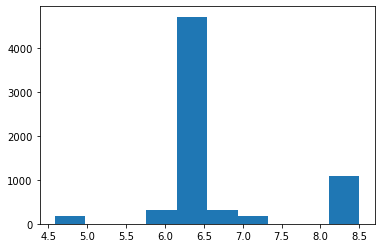

In [32]:
plt.hist(df_daily['nbr_h_WGopen']);

In [33]:
#bird based on : df_daily[df_daily['Max_duration_WG']>0].tail(15)
h = 'hen_9'
d = dt.datetime(2022,2,2) #until 3h00-17h00 day time and wg opened at 10h-16h20
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_WG].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

,HenID,level,CorrectPenID,time_wg_open_sec,duration_sincedaystarted_beforeWGopened_sec,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,nbr_h_WGopen,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,WentinWG
3939,hen_9,2022-02-02,pen10,22800.0,36000.0,4200.0,8.0,18.421053,2022-02-02 12:17:17,6.333333,44237.0,2.288056,8.0,1


((Timestamp('2022-02-02 03:07:29'), '3_Zone'),
 (Timestamp('2022-02-02 04:04:02'), '2_Zone'),
 (Timestamp('2022-02-02 04:27:34'), '3_Zone'),
 (Timestamp('2022-02-02 04:31:47'), '4_Zone'),
 (Timestamp('2022-02-02 04:39:29'), '5_Zone'),
 (Timestamp('2022-02-02 04:41:20'), '4_Zone'),
 (Timestamp('2022-02-02 05:25:32'), '3_Zone'),
 (Timestamp('2022-02-02 05:37:01'), '2_Zone'),
 (Timestamp('2022-02-02 06:04:41'), '3_Zone'),
 (Timestamp('2022-02-02 06:36:28'), '2_Zone'),
 (Timestamp('2022-02-02 07:03:57'), '3_Zone'),
 (Timestamp('2022-02-02 07:29:40'), '2_Zone'),
 (Timestamp('2022-02-02 07:35:36'), '3_Zone'),
 (Timestamp('2022-02-02 07:59:40'), '2_Zone'),
 (Timestamp('2022-02-02 08:02:14'), '3_Zone'),
 (Timestamp('2022-02-02 08:19:33'), '2_Zone'),
 (Timestamp('2022-02-02 10:00:08'), '3_Zone'),
 (Timestamp('2022-02-02 10:02:23'), '2_Zone'),
 (Timestamp('2022-02-02 10:04:58'), '3_Zone'),
 (Timestamp('2022-02-02 10:33:17'), '2_Zone'),
 (Timestamp('2022-02-02 11:35:30'), '3_Zone'),
 (Timestamp('

In [34]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_WG]
print(len(li_var_TODO))
display(li_var_TODO)

24


['HenID',
 'level',
 'verification_daily_total_nbr_hour',
 'dur_values',
 'dur_values_normalized',
 'mid_cum_Z4_sec',
 'distribution_entropy',
 'nestboxes_related_behavior',
 'TagID',
 'nbr_h_per_day',
 'correct_amount_of_hour',
 'DOA',
 'WOA',
 'weekday',
 'TrackingSystemID',
 'day_lighth',
 'mid_cum_Z4_h_Morning',
 'previous_mid_cum_Z4_h_Morning',
 'Intervaltime_midcumZ4hmorning_h',
 'Period_type',
 'HenID_Period',
 'HenID_date',
 'system',
 'CorrectPenID']

# entropy

In [35]:
df_daily[['distribution_entropy','dur_values_normalized','dur_values']]

,distribution_entropy,dur_values_normalized,dur_values
0,0.537906,"[0.8770061728395062, 0.12299382716049383, 0.0,...","[28415.0, 3985.0, 0.0, 0.0]"
1,1.087759,"[0.6753395061728396, 0.28339506172839507, 0.04...","[21881.0, 9182.0, 1337.0, 0.0]"
2,0.609222,"[0.850246913580247, 0.14975308641975307, 0.0, ...","[27548.0, 4852.0, 0.0, 0.0]"
3,0.797941,"[0.7921604938271605, 0.19719135802469137, 0.01...","[25666.0, 6389.0, 345.0, 0.0]"
4,0.487314,"[0.8941358024691358, 0.10586419753086419, 0.0,...","[28970.0, 3430.0, 0.0, 0.0]"
...,...,...,...
7592,1.776948,"[0.0, 0.14662698412698413, 0.288015873015873, ...","[0.0, 7390.0, 14516.0, 5221.0, 23273.0]"
7593,0.681380,"[0.0, 0.03, 0.08456349206349206, 0.00904761904...","[0.0, 1512.0, 4262.0, 456.0, 44170.0]"
7594,1.383110,"[0.0, 0.14753968253968253, 0.20851190476190476...","[0.0, 7436.0, 10509.0, 687.0, 31768.0]"
7595,1.808571,"[0.0, 0.1850595238095238, 0.2029563492063492, ...","[0.0, 9327.0, 10229.0, 6580.0, 24264.0]"


In [36]:
from scipy.stats import entropy
#Note: order does not matter, number of 0min in a zone does not matter
print(entropy([0.0, 0.0, 780.0, 325.0, 31295.0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0,0,0,0,0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0], base=2),
entropy([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], base=2),
entropy([1/5, 1/5, 1/5, 1/5, 1/5], base=2),
entropy([1/4, 1/4, 1/4, 1/4], base=2))

0.24438458187120013 0.15812999407546002 0.15812999407546005 2.584962500721156 2.3219280948873626 2.0


In [37]:
#max entropy with 5 zones
nbr_zone = 5
print(math.log(nbr_zone, 2), entropy([1,1,1,1,1],base=2))
if round(math.log(nbr_zone, 2),8)!=round(entropy([1,1,1,1,1],base=2),8):
    print('ERROR 1')
    sys.exit()
if df_daily['distribution_entropy'].max()>math.log(nbr_zone, 2):
    print('ERROR 2')
    sys.exit()

2.321928094887362 2.3219280948873626


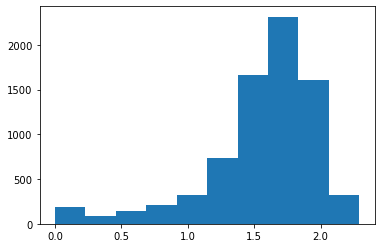

In [38]:
plt.hist(df_daily['distribution_entropy']);

## Other

In [39]:
df_daily['verification_daily_total_duration'].value_counts()

50400.0    6298
32400.0     807
48600.0     492
Name: verification_daily_total_duration, dtype: int64

# Save for visual verification

In [40]:
li_dur = ['duration_1_Zone','duration_2_Zone','duration_3_Zone','duration_4_Zone','duration_5_Zone']
for x in li_dur:
    df_daily[x+'_min'] = df_daily[x].map(lambda x: x/60)

In [41]:
#to control for
df_daily['Has_been_toptier_wholeday'] = df_daily['perc_duration_5_Zone'].map(lambda x: x==100)
df_daily['Has_been_toptier_wholeday'].value_counts()

False    7479
True      118
Name: Has_been_toptier_wholeday, dtype: int64

In [42]:
df_daily['CorrectPenID'].unique()

array(['pen10', 'pen4', 'pen5', 'pen8', 'pen9', 'pen11', 'pen12', 'pen3',
       'pen11-pen12', 'pen4-pen3'], dtype=object)

In [43]:
df_daily_ = df_daily.drop(['dur_values_normalized','SleepingHeight','Sleeping_NotUppest','previous_mid_cum_Z4_h_Morning',
                          'perc_duration_1_Zone','night_duration_Z5','list_of_durations','verification_daily_total_duration',
                          'night_Total_number_transition','dur_values','duration_sincedaystarted_beforeWGopened_sec',
                          'FirstTimestamp_2_Zone','FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone',
                          'FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','nbr_stays','distribution_entropy',
                          'correct_amount_of_hour','verification_daily_total_nbr_hour','is_mvt_night','time_wg_open_sec',
                          'nbr_stays_total','mid_durationafterlightturnedon_Z4_h_Morning']+li_dur,axis=1)
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'),sep=';',index=False)
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified_comma.csv'),sep=',',index=False)

print(df_daily_.shape)
df_daily_.head(3)

(7597, 44)


,HenID,level,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_zone,mid_cum_Z4_sec,Total_number_transition,vertical_travel_distance,...,HenID_Period,HenID_date,system,CorrectPenID,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday
0,hen_1,2021-10-09,12.0,88.0,0.0,0.0,2.0,NaN,6.0,6.0,...,hen_1_early,hen_1-2021-10-09,10-12,pen10,NaN,473.583333,66.416667,0.000000,0.0,False
1,hen_1,2021-10-10,28.0,68.0,4.0,0.0,3.0,13346.0,14.0,14.0,...,hen_1_early,hen_1-2021-10-10,10-12,pen10,NaN,364.683333,153.033333,22.283333,0.0,False
2,hen_1,2021-10-16,15.0,85.0,0.0,0.0,2.0,NaN,6.0,6.0,...,hen_1_early,hen_1-2021-10-16,10-12,pen10,NaN,459.133333,80.866667,0.000000,0.0,False


In [44]:
df_daily_.columns

Index(['HenID', 'level', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
       'perc_duration_4_Zone', 'perc_duration_5_Zone', 'Total_number_zone',
       'mid_cum_Z4_sec', 'Total_number_transition', 'vertical_travel_distance',
       'nestboxes_related_behavior', 'nbr_stays_3_Zone', 'nbr_stays_2_Zone',
       'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'TagID', 'night_level',
       'night_Max_duration_zones', 'nbr_h_per_day', 'DOA', 'WOA',
       'perc_1_Zone_while_WG_open', 'nbr_h_WGopen', 'latency_1_Zone_h',
       'nbr_stays_1_Zone', 'weekday', 'TrackingSystemID', 'Sleeping_Uppest',
       'WentinWG', 'vertical_travel_distance_perinsideh', 'day_lighth',
       'mid_cum_Z4_h_Morning', 'Intervaltime_midcumZ4hmorning_h',
       'Period_type', 'HenID_Period', 'HenID_date', 'system', 'CorrectPenID',
       'duration_1_Zone_min', 'duration_2_Zone_min', 'duration_3_Zone_min',
       'duration_4_Zone_min', 'duration_5_Zone_min',
       'Has_been_toptier_wholeday'],
      dtype='object')

In [45]:
df_daily.groupby(['Period_type','day_lighth']) ['HenID'].count().reset_index()
#as 8h: no mid nestox usage, beside this we only have three! so lets remove mid_durationafterlightturnedon_Z4_h_Morning and 
#keep the time of the day instead (=mid_cum_Z4_h_Morning)

,Period_type,day_lighth,HenID
0,R1,3,1314
1,R2,3,1923
2,R3,3,2452
3,early,8,807
4,late,3,1101
